### Generate training data: channels and approximate channel inverses 
### Generate test data: channels and approximate channel inverses

In [1]:
import numpy as np
import scipy.signal as sig
from numpy import linalg as LA
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Create training and test data for the NN

# number of random channels that will be trained and tested on
num_train=1000000# 1000000
num_test=1000000
SNR = 10

# assume we know the channel_length
channel_length = 2
num_preambles = 10
preamble_length = 10
recieved_length = preamble_length + channel_length - 1

preambles = np.random.randint(0,2,(num_preambles,preamble_length)) 

def add_awgn_noise(signal,SNR_dB):
    """  Adds AWGN noise vector to signal 
         to generate a resulting signal vector y of specified SNR in dB
    """
    L=len(signal)
    SNR = 10**(SNR_dB/10.0) #SNR to linear scale
    Esym=np.sum(np.square(np.abs(signal)))/L #Calculate actual symbol energy
    N0=Esym/SNR; #Find the noise spectral density
    if(isinstance(signal[0], complex)):
        noiseSigma=np.sqrt(N0/2.0)#Standard deviation for AWGN Noise when x is complex
        n = noiseSigma*(np.random.randn(1,L)+1j*np.random.randn(1,L))#computed noise 
    else:
        noiseSigma = np.sqrt(N0);#Standard deviation for AWGN Noise when x is real
        n = noiseSigma*np.random.randn(1,L)#computed noise
    y = signal + n #received signal
    return signal

# channel_train: assume we are working with just real parts, list of all used channels
# preamble_train: use same channel on num_preambles different preambles and store them to train with
# inverse_train: contains channel_inverse per preamble, inverse is composed of [1/a0, -a1/a0, ...... -an/a0]
channel_train = np.zeros((num_train,channel_length))
preamble_train = np.zeros((num_train*num_preambles, recieved_length))
inverse_train = np.zeros((num_train*num_preambles,channel_length))

channel_test = np.zeros((num_train,channel_length))
preamble_test = np.zeros((num_train*num_preambles, recieved_length))
inverse_test = np.zeros((num_train*num_preambles,channel_length))

for i in range(0, num_train):
    channel_train[i,:]=np.random.uniform(0.2,1,channel_length)
    # if the total power is greater than 1, then normalize
    if sum(channel_train[i])>=1:
        channel_train[i] = channel_train[i]/(sum(channel_train[i]))
        
    for k in range(num_preambles):
        preamble_train[i+k,:] = add_awgn_noise(sig.convolve(preambles[k], channel_train[i], mode='full'), SNR)
        inverse_train[i+k,0] = 1/channel_train[i,0]
        for j in range(1, channel_length):
            inverse_train[i+k,j] = -channel_train[i,j]/channel_train[i,0]

        
        
for i in range(0, num_test):
    channel_test[i,:]=np.random.uniform(0.2,1,channel_length)
    # if the total power is greater than 1, then normalize
    if sum(channel_test[i])>=1:
        channel_test[i] = channel_test[i]/(sum(channel_test[i]))
        
    for k in range(num_preambles):
        preamble_test[i+k,:] = add_awgn_noise(sig.convolve(preambles[k], channel_test[i], mode='full'), SNR)
        inverse_test[i+k,0] = 1/channel_test[i,0]
        for j in range(1, channel_length):
            inverse_test[i+k,j] = -channel_test[i,j]/channel_test[i,0]

Epoch 0, Cost 0.06942559778690338, Test Cost: 0.0770639181137085
Epoch 100, Cost 0.017885461449623108, Test Cost: 0.008487788960337639
Epoch 200, Cost 0.10304037481546402, Test Cost: 0.005742689128965139
Epoch 300, Cost 0.174800306558609, Test Cost: 0.0074842749163508415
Epoch 400, Cost 0.0021680707577615976, Test Cost: 0.007593914400786161
Epoch 500, Cost 0.06491932272911072, Test Cost: 0.007028133608400822
Epoch 600, Cost 0.018567247316241264, Test Cost: 0.006627642549574375
Epoch 700, Cost 7.002618804108351e-05, Test Cost: 0.005847664549946785
Epoch 800, Cost 0.006843630224466324, Test Cost: 0.005582490935921669
Epoch 900, Cost 0.000849061063490808, Test Cost: 0.004425335675477982


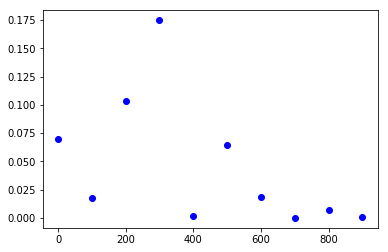

In [3]:
# fix a random seed to have the same results
np.random.seed()

learning_rate = 0.001
epochs = 10000#10000
batch_size = 1000
test_averaging=100
decay = 1 - 10*1e-10

# placeholders for input and output
adaptive_learning_rate = tf.placeholder_with_default(learning_rate, [])
recieved_preamble = tf.placeholder(tf.float32, [None, recieved_length])
real_inverse = tf.placeholder(tf.float32, [None, channel_length])

layer1 = tf.contrib.layers.fully_connected(recieved_preamble, num_outputs=150, activation_fn=tf.nn.tanh)
layer2 = tf.contrib.layers.fully_connected(layer1, num_outputs=150, activation_fn=tf.nn.tanh)
layer3 = tf.contrib.layers.fully_connected(layer2, num_outputs=channel_length, activation_fn=tf.identity)

inverse_channel = layer3

cost_fn = tf.reduce_mean(tf.reduce_mean((real_inverse-inverse_channel)**2, axis=1))
optimizer = tf.train.AdamOptimizer(learning_rate=adaptive_learning_rate).minimize(cost_fn)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
plt.figure()


with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        
        # for each batch start the batch with passing the first preamble through the identity channel
        identity_channel = np.zeros(channel_length)
        identity_channel[0] = 1
        preamble_batch = sig.convolve(preambles[0], identity_channel, mode='full')
        real_inv_batch = identity_channel
        
        for rand in range(0,batch_size-1):
            rand_int = np.random.randint(0,num_train*num_preambles)
            preamble_batch = np.vstack((preamble_batch, preamble_train[rand_int]))
            real_inv_batch = np.vstack((real_inv_batch, inverse_train[rand_int]))
            
        preamble_batch.reshape((batch_size, recieved_length))
        real_inv_batch.reshape((batch_size, channel_length))
        
        _,cost,inverse_channel2 = sess.run(
            [optimizer, cost_fn, inverse_channel], 
            feed_dict={recieved_preamble: preamble_batch, 
                       real_inverse: real_inv_batch,adaptive_learning_rate: learning_rate * (decay**epoch)})
        if epoch % 100 == 0: 
            plt.plot(epoch, cost, 'bo')
            mc_cost, mc_inversion = sess.run(
                [cost_fn, inverse_channel], feed_dict={recieved_preamble: preamble_test, real_inverse: inverse_test})
            print('Epoch {}, Cost {}, Test Cost: {}'.format(epoch, cost, mc_cost))
            
    saved_model = saver.save(sess, 'my-test-model')